# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [3]:
genes = read.delim('../../_m/genes/diffExpr_maleVfemale_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Male Bias') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Female Bias') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}

sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000114374.12,ENSG00000114374,USP9Y,8.6836787,100.18087,1.953623e-272,< 2e-16,****,Male Bias,USP9Y
ENSG00000183878.15,ENSG00000183878,UTY,8.5971522,88.46621,8.133127e-253,< 2e-16,****,Male Bias,UTY
ENSG00000012817.15,ENSG00000012817,KDM5D,8.6930099,88.03682,3.593495e-252,< 2e-16,****,Male Bias,KDM5D
ENSG00000067048.16,ENSG00000067048,DDX3Y,8.5878028,86.79686,5.035188e-250,< 2e-16,****,Male Bias,DDX3Y
ENSG00000067646.11,ENSG00000067646,ZFY,8.5329011,81.80364,9.106019e-241,< 2e-16,****,Male Bias,ZFY
ENSG00000229807.10,ENSG00000229807,XIST,-9.2961371,-100.35608,1.953623e-272,< 2e-16,****,Female Bias,XIST
ENSG00000005889.15,ENSG00000005889,ZFX,-0.6315196,-46.06126,3.887766e-155,< 2e-16,****,Female Bias,ZFX
ENSG00000147050.14,ENSG00000147050,KDM6A,-0.5283117,-31.99315,3.017839e-107,< 2e-16,****,Female Bias,KDM6A
ENSG00000126012.11,ENSG00000126012,KDM5C,-0.4877813,-31.52353,1.766719e-105,< 2e-16,****,Female Bias,KDM5C


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,ENSG00000130021.13,ENSG00000005889.15,ENSG00000147050.14,ENSG00000126012.11,ENSG00000229807.10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12864,1.7296843,2.2011553,0.7197812,0.7777431,1.511303
R12865,-0.6949843,-0.7467199,-0.5590480,-0.3426528,-1.266569


### Load pheno data

In [5]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv'
pheno <- data.table::fread(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("V1")
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R12864,Br1303,R12864,Caudate,9.6,42.98,Female,AA,Schizo
R12865,Br1320,R12865,Caudate,9.5,53.12,Male,AA,Schizo


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 393  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000130021.13
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R12864,Br1303,R12864,Caudate,9.6,42.98,Female,AA,Schizo,1.7296843
2,R12865,Br1320,R12865,Caudate,9.5,53.12,Male,AA,Schizo,-0.6949843


### Melt data frame

In [7]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R12864,Female,ENSG00000130021.13,1.729684,ENSG00000130021,PUDP,-0.5965470,-27.93309,1.650254e-91,< 2e-16,****,Female Bias,PUDP
R12864,Female,ENSG00000005889.15,2.201155,ENSG00000005889,ZFX,-0.6315196,-46.06126,3.887766e-155,< 2e-16,****,Female Bias,ZFX


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


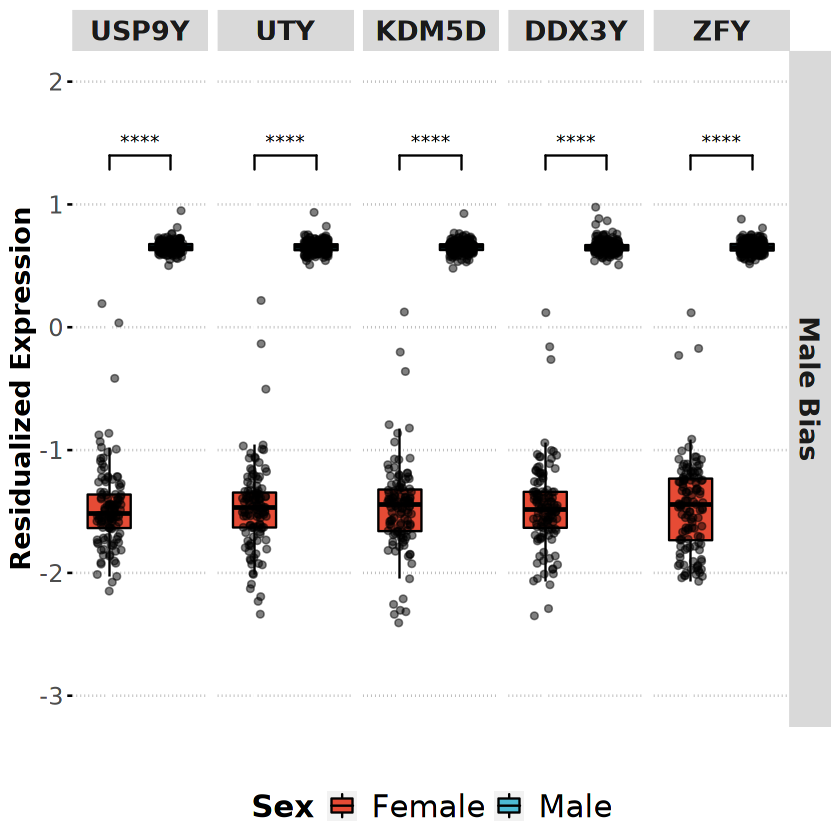

In [8]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=1.4) %>% filter(Direction == 'Male Bias') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Male Bias") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), fill="Sex", xlab='', 
                  panel.labs.font=list(face='bold', size = 16), palette="npg", outlier.shape=NA,
                  ylab='Residualized Expression', add='jitter', ylim=c(-3, 2),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


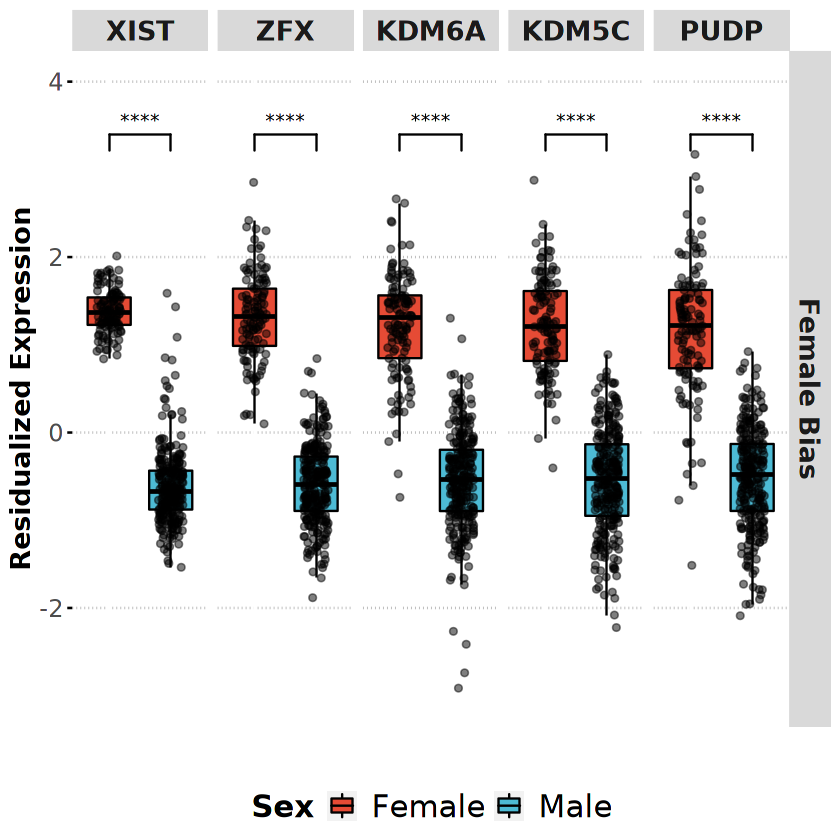

In [9]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=3.4) %>% 
    filter(Direction == 'Female Bias') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=='Female Bias') %>% 
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                  facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16), 
                  ylab='Residualized Expression', add='jitter', ylim=c(-3, 4),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

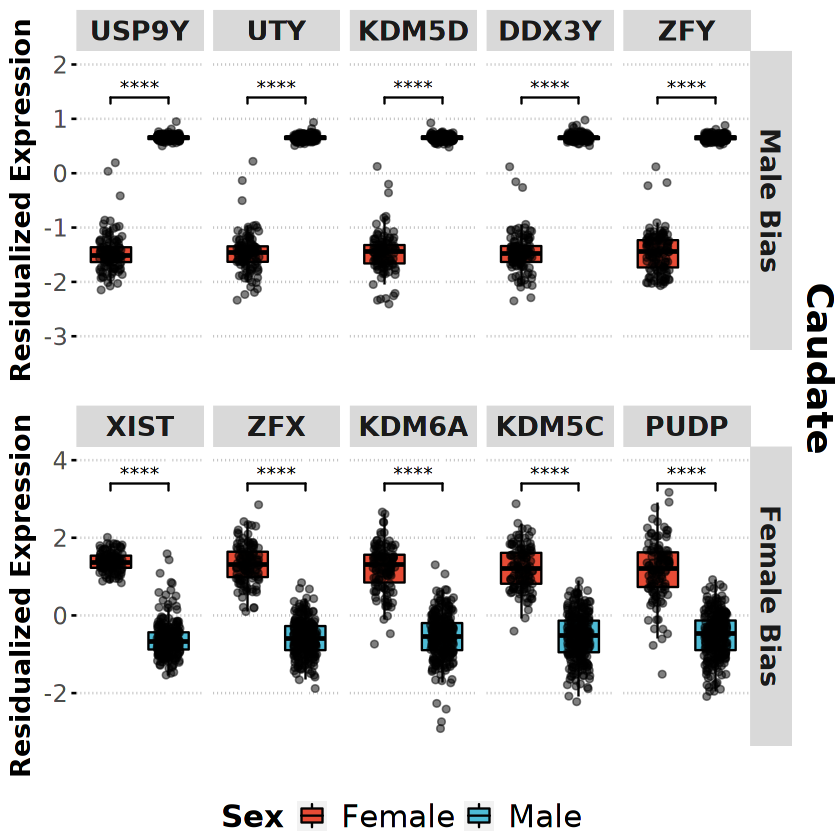

In [10]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow=2, common.legend=TRUE, legend='bottom')
figure <- annotate_figure(figure, 
                          right=text_grob("Caudate", size=22, rot=-90, face='bold', hjust=0.8))
figure

In [11]:
save_ggplots('caudate_topSig_boxplot', figure, 12, 8)

## Autosomal only

### Differential expressed genes

In [12]:
genes = read.csv('../../metrics_summary/_m/autosomal_DEG.csv')
genes = genes %>% rename("gencodeID" = "Feature") %>% 
        filter(adj.P.Val < 0.05) %>%  
        select(gencodeID, ensemblID, Symbol, logFC, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(logFC > 0) %>% mutate('Direction'='Male Bias') %>% head(5) 
down_genes = genes %>% filter(logFC < 0) %>% mutate('Direction'='Female Bias') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(as.character(sig_genes$Symbol[xx]) == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

gencodeID,ensemblID,Symbol,logFC,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000205611.4,ENSG00000205611,LINC01597,1.3079897,6.877867e-20,< 2e-16,****,Male Bias,LINC01597
ENSG00000283443.1,ENSG00000283443,,1.4162533,2.838705e-18,< 2e-16,****,Male Bias,ENSG00000283443
ENSG00000149531.15,ENSG00000149531,FRG1BP,0.6715762,1.190836e-17,< 2e-16,****,Male Bias,FRG1BP
ENSG00000282826.1,ENSG00000282826,FRG1CP,0.5551378,1.474014e-15,1.5e-15,****,Male Bias,FRG1CP
ENSG00000258484.3,ENSG00000258484,SPESP1,0.7304981,4.974455e-12,5.0e-12,****,Male Bias,SPESP1
ENSG00000095932.6,ENSG00000095932,SMIM24,-0.9013291,1.022672e-15,1.0e-15,****,Female Bias,SMIM24
ENSG00000261600.1,ENSG00000261600,,-0.9681869,3.921912e-13,3.9e-13,****,Female Bias,ENSG00000261600
ENSG00000236698.1,ENSG00000236698,EIF1AXP1,-0.2509585,2.863151e-12,2.9e-12,****,Female Bias,EIF1AXP1
ENSG00000241532.1,ENSG00000241532,AGGF1P3,-0.7277903,8.886125e-11,8.9e-11,****,Female Bias,AGGF1P3


### Load residualized expression

In [13]:
resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

,ENSG00000236698.1,ENSG00000261600.1,ENSG00000241532.1,ENSG00000180574.3,ENSG00000258484.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12864,-0.0355813,0.4617652,0.05548178,2.0144561,-1.56986609
R12865,-1.1127706,-1.1681747,0.50413144,-0.5880534,0.02374568


### Merge dataframe

In [14]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 393  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000236698.1
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R12864,Br1303,R12864,Caudate,9.6,42.98,Female,AA,Schizo,-0.0355813
2,R12865,Br1320,R12865,Caudate,9.5,53.12,Male,AA,Schizo,-1.1127706


### Melt data frame

In [15]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    mutate_if(is.character, as.factor) %>% inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,adj.P.Val,FDR,p.signif,Direction,New_ID
<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R12864,Female,ENSG00000236698.1,-0.0355813,ENSG00000236698,EIF1AXP1,-0.2509585,2.863151e-12,2.9e-12,****,Female Bias,EIF1AXP1
R12864,Female,ENSG00000261600.1,0.4617652,ENSG00000261600,,-0.9681869,3.921912e-13,3.9e-13,****,Female Bias,ENSG00000261600


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


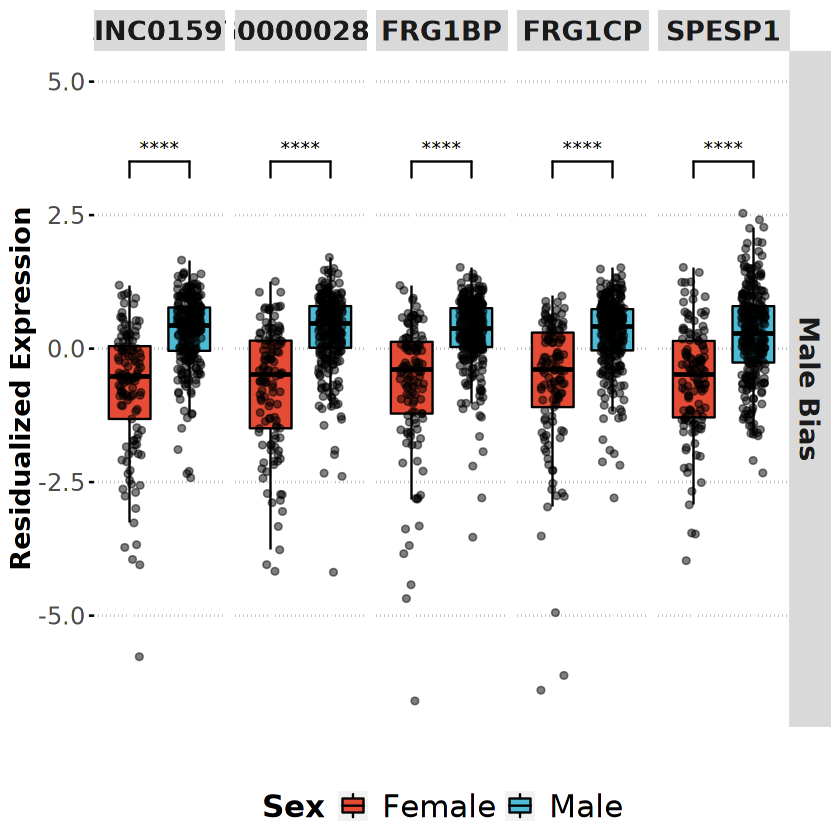

In [16]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=3.5) %>% filter(Direction == 'Male Bias') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction == "Male Bias") %>% 
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                    facet.by=c("Direction", "New_ID"), panel.labs.font=list(face='bold', size = 16),
                    ylab='Residualized Expression', add='jitter', ylim=c(-6.5, 5), 
                    add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


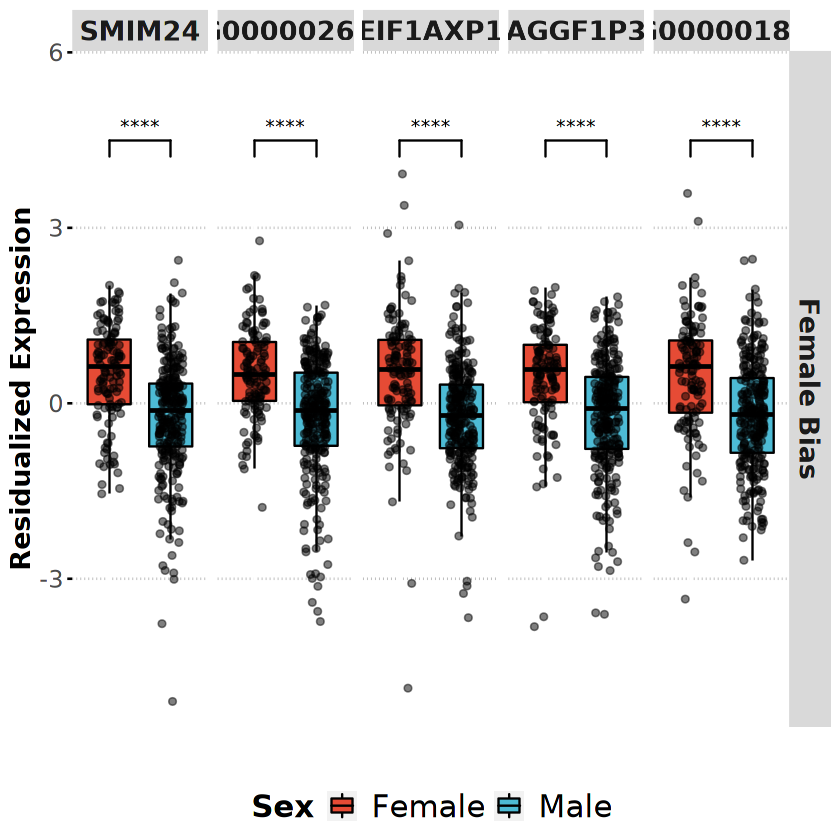

In [17]:
tmp = sig_genes %>% mutate(group1='Female', group2='Male', y_pos=4.5) %>% 
    filter(Direction == 'Female Bias') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Female Bias") %>%
        ggboxplot(x="Sex", y="Res", fill="Sex", palette="npg", xlab='', outlier.shape=NA,
                  facet.by=c("Direction", "New_ID"), 
                  panel.labs.font=list(face='bold', size = 16),    
                  ylab='Residualized Expression', add='jitter', ylim=c(-5, 5.5),
                  add.params=list(alpha=0.5), legend="bottom", ggtheme=theme_pubclean()) +
         geom_signif(data=tmp, 
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
         font("legend.title", size=18, face="bold") + 
         font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

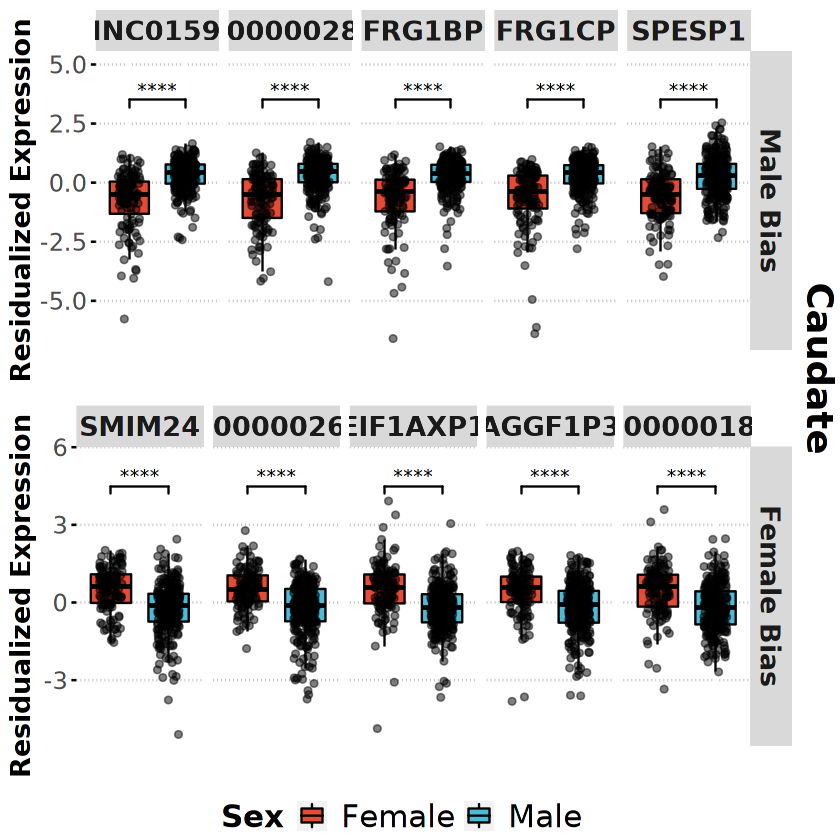

In [18]:
figure2 <- ggarrange(bxp_up, bxp_down, ncol=1, nrow=2, common.legend=TRUE, legend='bottom')
figure2 <- annotate_figure(figure2, 
                           right=text_grob("Caudate", size=22, rot=-90, face='bold', hjust=0.8))
figure2

In [19]:
save_ggplots('caudate_topSig_autosomal_boxplot', figure2, 12, 8)

## Session Info

In [20]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-09 20:49:18 EDT"

   user  system elapsed 
 21.941   1.930  22.776 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-09                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 